# PyTorch Layer 이해하기

# 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

In [4]:
image, label = next(iter(train_loader))

In [9]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

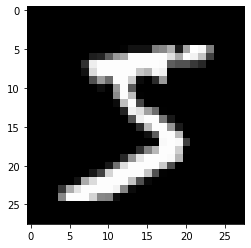

In [10]:
plt.imshow(image[0,0,:,:], 'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [5]:
import torch
import torch.nn as nn # nn은 안에 weight가 있는 것
import torch.nn.functional as F # functional은 maxpooling이나 activation 등(weight값이 없는 것)

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [11]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
# tensorflow와는 조금 다르지, tensorflow에서는 out_channels만 나왔음(얼마나 내보낼 것인지)
# PyTorch는 in_channels로 몇 개를 받을 것인지 정해줘야해
# 앞에서 채널이 1개였기때문에 (흑백) 1로 설정했음
# kernel_size는 전에는 (3,3)이었는데 pytorch 예제에선 (5,5)라 5

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [13]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [15]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [16]:
weight = weight.numpy()
# detach()안해주면 안됨

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [17]:
weight = weight.detach().numpy()

In [18]:
weight # numpy화가 됐음

array([[[[-0.06645329,  0.06448726, -0.12705389, -0.09000273,
          -0.09869883],
         [-0.14863269,  0.12743999,  0.03341718,  0.0508642 ,
          -0.16204643],
         [-0.09666455, -0.02656642, -0.05512592,  0.01451099,
          -0.1603847 ],
         [ 0.12239228,  0.10740845, -0.00478561,  0.15303989,
          -0.09492171],
         [ 0.10666789,  0.14051355,  0.02337618, -0.01452637,
           0.1766452 ]]],


       [[[-0.08249245,  0.03777108, -0.14979275, -0.08811729,
          -0.16327326],
         [-0.07290411,  0.04354446, -0.05606285, -0.02109592,
           0.12571059],
         [ 0.19114028, -0.14823553,  0.16236256, -0.05674188,
           0.0602469 ],
         [ 0.1832666 ,  0.190071  ,  0.16923912,  0.10554399,
           0.10794853],
         [ 0.13940312,  0.0701832 ,  0.17510428,  0.01253542,
          -0.19794214]]],


       [[[ 0.19633187, -0.05573161,  0.0894842 , -0.18945912,
           0.07433598],
         [-0.15312722, -0.11864591, -0.0237497

In [19]:
weight.shape

(20, 1, 5, 5)

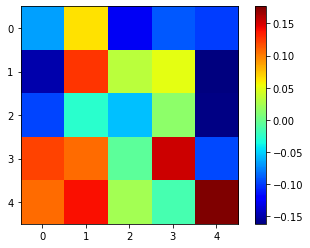

In [20]:
plt.imshow(weight[0,0,:,:], 'jet')
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [21]:
output_data = layer(image) # Conv2d 거침

In [27]:
output_data = output_data.data # data화

In [28]:
output = output_data.cpu().numpy() # numpy화

In [29]:
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [30]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

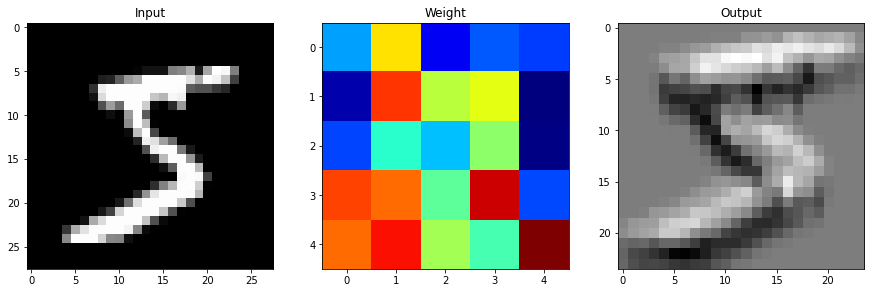

In [31]:
plt.figure(figsize=(15,30))
plt.subplot(131)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray') # 위에 image_arr.shape를 보면 앞에 1이있기때문에 squeeze 통해 차원 축소해줘야함
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0,0,:,:], 'jet')
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0,0,:,:], 'gray')
plt.show()

# input이 conv에서 weight와 결합해서 output이 나오는 상태!

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [32]:
image.shape

torch.Size([1, 1, 28, 28])

In [33]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [34]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [35]:
image_arr.shape

(1, 1, 28, 28)

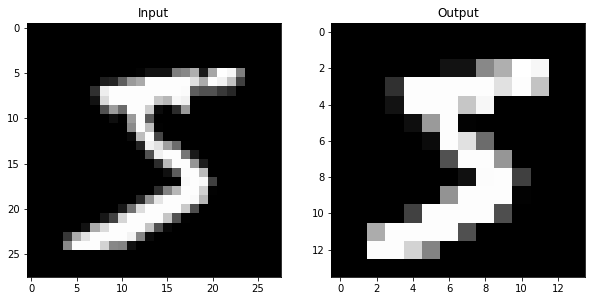

In [37]:
plt.figure(figsize=(10,15))
plt.subplot(121)
plt.title('Input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray')
plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [38]:
image.shape

torch.Size([1, 1, 28, 28])

In [39]:
# flatten()이 따로 없기때문에 reshape이나 view()를 사용해서 펼쳐줘야해
flatten = image.view(1, 28*28) # 맨 앞에 1은 batch_size와 똑같이 남겨줘야해 (만약 image.shape가 [64, 1, 28, 28]이면 똑같이 image.view(64,) 이렇게)
flatten.shape

torch.Size([1, 784])

In [40]:
lin = nn.Linear(784, 10)(flatten) # 784개 받고 10개로 내보낸다
lin.shape

torch.Size([1, 10])

In [41]:
lin

tensor([[ 1.6741e-01, -1.7438e-03,  2.2044e-04, -1.0609e-01, -5.4857e-02,
          1.3126e-03,  1.2322e-01, -9.9238e-02,  4.0554e-01,  2.0868e-01]],
       grad_fn=<AddmmBackward>)

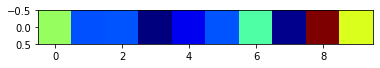

In [43]:
plt.imshow(lin.detach().numpy(), 'jet') # lin에는 weight가 있기때문에 detach()해줘야해
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [44]:
# 이번엔 detach()말고 torch.no_grad()사용해서 안에 있는 weight 무시하게끔
with torch.no_grad():
    flatten = image.view(1, 28*28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1) # no_grad()안해주면 softmax 볼 수 없어(학습모드일땐 안돼)

In [45]:
softmax

tensor([[0.1013, 0.1028, 0.0903, 0.1009, 0.0958, 0.0902, 0.0748, 0.1371, 0.1054,
         0.1013]])

In [47]:
np.sum(softmax.numpy()) # 1에 가까운 숫자나옴

0.99999994

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x): # 위 init을 통해 학습이 가능한 layer만들었으면 여기선 적용
        # Feature Extraction
        x = F.relu(self.conv1(x)) # conv1이 바로 conv2로 가는 게 아니고 relu와 max_pool을 거침
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
#        print(x.shape) # Linear와 view에 들어갈 size를 알기위해 중간에 print찍어서 shape 확인용
        # Fully Connected(Classification)
        x = x.view(-1, 4*4*50) # 앞에 batch_size를 뭘로 받을지 몰라서 -1로 줬음
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

- Image를 Model에 넣어서 결과 확인

In [60]:
model = Net()

In [61]:
result = model.forward(image) 
# 위에서 print(x.shape)했던 게 출력됨
# [50, 4, 4]는 batch_size가 어떻게 나오든 고정이니까 class만들어줄 때 4*4*50

torch.Size([1, 50, 4, 4])


In [58]:
result # image 한번 넣고 난 뒤의 결과

tensor([[-2.2938, -2.2449, -2.2767, -2.3286, -2.3776, -2.2709, -2.3075, -2.2797,
         -2.3163, -2.3365]], grad_fn=<LogSoftmaxBackward>)